# Forecast Future Market Trends - colab version

Setup and Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import joblib, pickle
from datetime import timedelta

Load Saved Model and Variables

In [ ]:
model = load_model("lstm_model.h5")
scaler = joblib.load("scaler.save")
with open("lstm_vars.pkl", "rb") as f:
    vars_loaded = pickle.load(f)

SEQ_LEN = vars_loaded["SEQ_LEN"]
train = vars_loaded["train"]
test = vars_loaded["test"]

In [ ]:
# Combine historical data (train + test)
full_data = pd.concat([train, test])

Forecast Parameters

In [ ]:
forecast_days = 252  # ~12 months of trading days
last_sequence = full_data[-SEQ_LEN:].values  # Last sequence from historical data
last_sequence_scaled = scaler.transform(last_sequence.reshape(-1, 1))

Generate Predictions

In [ ]:
forecast_scaled = []
current_seq = last_sequence_scaled.reshape(1, SEQ_LEN, 1)

for _ in range(forecast_days):
    pred = model.predict(current_seq, verbose=0)[0][0]
    forecast_scaled.append(pred)

    # Update the sequence with the new prediction
    current_seq = np.append(current_seq[:, 1:, :], [[[pred]]], axis=1)

Inverse transform predictions to original price scale

In [ ]:
forecast_prices = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()

# --- Create Forecast DataFrame ---
last_date = full_data.index[-1]
forecast_dates = pd.date_range(start=last_date + timedelta(days=1), periods=forecast_days, freq="B")

forecast_df = pd.DataFrame({"Date": forecast_dates, "Forecast": forecast_prices})
forecast_df.set_index("Date", inplace=True)

Forecast vs Historical - Plot

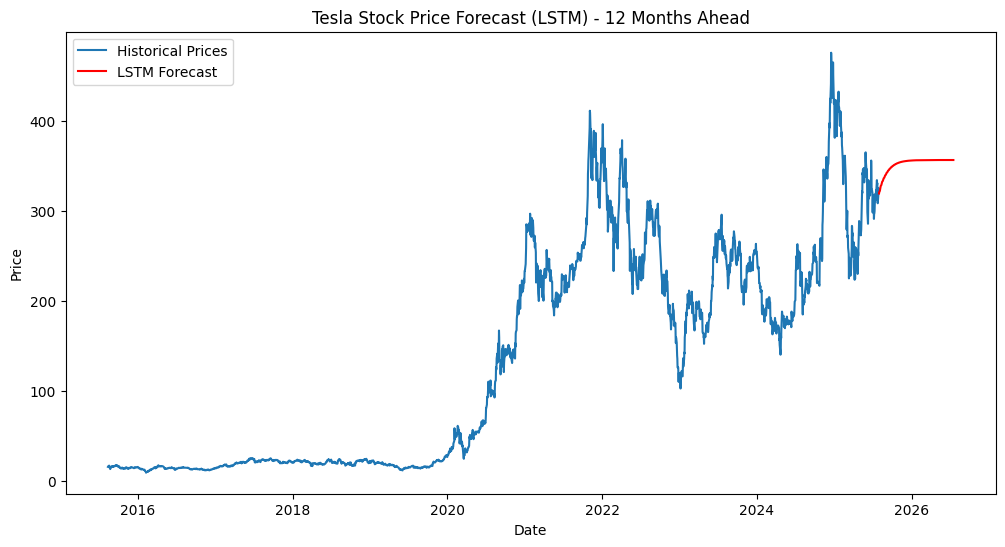

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(full_data.index, full_data.values, label="Historical Prices")
plt.plot(forecast_df.index, forecast_df["Forecast"], label="LSTM Forecast", color="red")
plt.title("Tesla Stock Price Forecast (LSTM) - 12 Months Ahead")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

Confidence Interval

In [ ]:
# I will use the standard deviation of the last 60 days residuals as uncertainty
residuals = test.values.flatten() - model.predict(
    scaler.transform(test.values.reshape(-1, 1)).reshape(-1, 1, 1),
    verbose=0
).flatten()

residual_std = np.std(residuals)
forecast_df["Lower_CI"] = forecast_df["Forecast"] - 1.96 * residual_std
forecast_df["Upper_CI"] = forecast_df["Forecast"] + 1.96 * residual_std

Forecast with Confidence Intervals - Plot

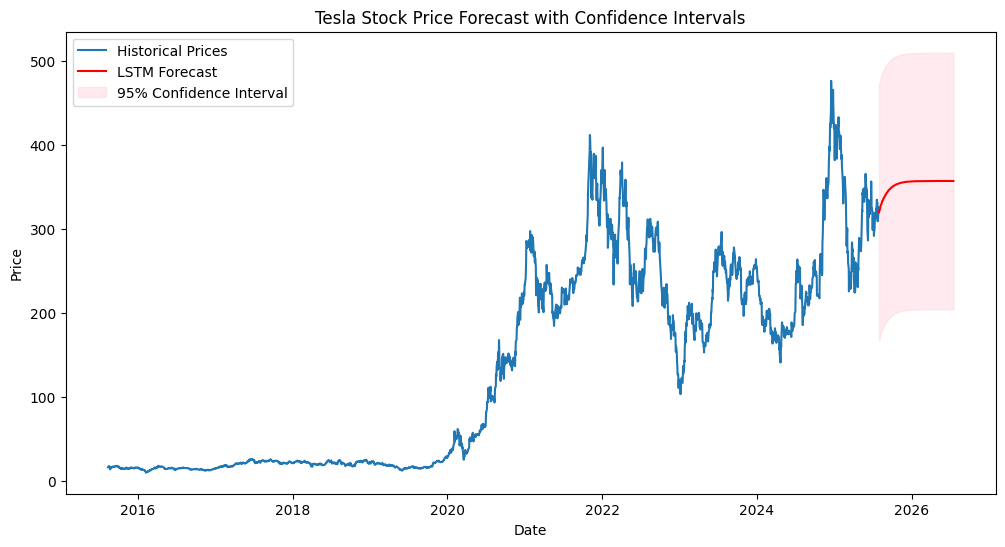

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(full_data.index, full_data.values, label="Historical Prices")
plt.plot(forecast_df.index, forecast_df["Forecast"], label="LSTM Forecast", color="red")
plt.fill_between(forecast_df.index, forecast_df["Lower_CI"], forecast_df["Upper_CI"],
                 color="pink", alpha=0.3, label="95% Confidence Interval")
plt.title("Tesla Stock Price Forecast with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

Analysis Outputs

In [ ]:
trend = "upward" if forecast_prices[-1] > forecast_prices[0] else "downward"
print(f"Trend Analysis: The forecast suggests a {trend} trend over the next {forecast_days} trading days.")
print(f"Confidence intervals widen over time, meaning increased uncertainty in long-term predictions.")
print(f"Volatility estimate based on recent residuals: ±{residual_std:.2f} USD")

Trend Analysis: The forecast suggests a upward trend over the next 252 trading days.
Confidence intervals widen over time, meaning increased uncertainty in long-term predictions.
Volatility estimate based on recent residuals: ±77.88 USD


In [ ]:
forecast_df.to_csv("forecast_df.csv")